In [1]:
import requests # to import files from Gutenberg

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# pytorch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torch
import torch.nn as nn
from torch.nn import functional as F

import random
import re
from typing import List, Tuple


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [3]:
from transformers import GPT2Tokenizer, AutoModelForCausalLM
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2 = AutoModelForCausalLM.from_pretrained("gpt2")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

# Set Hyperparameters

In [4]:
n_vocab = tokenizer.vocab_size
embed_dim = 768
seq_len = 256
CHUNK_SIZE = 256
n_heads = 12
n_blocks = 12
batch_size = 16

# Get the data from book Gulliver's Travels from gutenberg.org

In [6]:
# Function to download text
def download_text(url: str, timeout: int = 30) -> str:
    r = requests.get(url, timeout=timeout)
    r.raise_for_status()
    # Gutenberg is usually utf-8; if not, requests will guess
    return r.text


In [7]:
# Function to strip the text
def strip_gutenberg_boilerplate(raw: str) -> str:
    # Keep only content between START and END markers (if found)
    start_idx = raw.find(START_MARKER)
    if start_idx != -1:
        start_line_end = raw.find("\n", start_idx)
        raw = raw[start_line_end + 1:] if start_line_end != -1 else raw[start_idx + len(START_MARKER):]

    end_idx = raw.find(END_MARKER)
    if end_idx != -1:
        raw = raw[:end_idx]

    return raw.strip()


In [8]:
# Function to normalize whitespaces
def normalize_whitespace(s: str) -> str:
    s = s.replace("\r\n", "\n")
    s = re.sub(r"[ \t]+", " ", s)      # collapse spaces/tabs
    s = re.sub(r"\n{3,}", "\n\n", s)   # collapse huge blank gaps
    return s.strip()


In [9]:
# Split the text into blocks/ chunks
def chunk_text(s: str, chunk_size: int) -> List[str]:
    return [s[i:i + chunk_size] for i in range(0, len(s), chunk_size) if s[i:i + chunk_size].strip()]


In [10]:
# Split the data into train and test
def train_test_split(samples: List[str], train_ratio: float, seed: int) -> Tuple[List[str], List[str]]:
    rng = random.Random(seed)
    rng.shuffle(samples)
    n_train = int(len(samples) * train_ratio)
    return samples[:n_train], samples[n_train:]


In [11]:
URL = "https://www.gutenberg.org/files/829/829-0.txt"  # Gulliver's Travels (plain text)
TRAIN_RATIO = 0.9
SEED = 42
CHUNK_SIZE = 256  # same as sequence length

START_MARKER = "*** START OF THE PROJECT GUTENBERG EBOOK"
END_MARKER   = "*** END OF THE PROJECT GUTENBERG EBOOK"

raw = download_text(URL)
text = strip_gutenberg_boilerplate(raw)
text = normalize_whitespace(text)

chunks = chunk_text(text, CHUNK_SIZE)
train_chunks, test_chunks = train_test_split(chunks, TRAIN_RATIO, SEED)

print(f"Total chunks: {len(chunks)}")
print(f"Train chunks: {len(train_chunks)}")
print(f"Test chunks:  {len(test_chunks)}")

# train_chunks and test_chunks now exist ONLY in memory
# Example: inspect one sample
print("\nSample train chunk (first 300 chars):\n")
print(train_chunks[0][:300])


Total chunks: 2275
Train chunks: 2047
Test chunks:  228

Sample train chunk (first 300 chars):


Bolgolam in person attended by two under-secretaries, and several
persons of distinction. After they were read, I was demanded to swear
to the performance of them; first in the manner of my own country, and
afterwards in the method prescribed by their law


In [12]:
# Tokenize the chunks
train_data = tokenizer.encode(train_chunks)
test_data = tokenizer.encode(test_chunks)

Token indices sequence length is longer than the specified maximum sequence length for this model (2047 > 1024). Running this sequence through the model will result in indexing errors


In [13]:
print(train_data)

[50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256

# Method - 2 to split into train and test data

In [14]:
# tokenize the text
# Gulliver's travels :)
text = requests.get('https://www.gutenberg.org/cache/epub/829/pg829.txt').text
gtTokens = torch.tensor( tokenizer.encode(text),dtype=torch.long )
len(gtTokens)

158345

In [15]:
# train/test split

train_ratio = .9

# index to split data
test_split_point = int(train_ratio*len(gtTokens))

train_data = gtTokens[:test_split_point]
test_data  = gtTokens[test_split_point:]


# a function that returns a batch of data samples
def get_data_batch(training=True):

  # pick the dataset to use
  if training:
    data = train_data
  else:
    data = test_data

  # pick random indices to start
  ix = torch.randint(len(data)-seq_len,size=(batch_size,))

  # get the data and targets (via broadcasting outer product)
  X = data[ix[:,None] + torch.arange(seq_len)]
  y = data[ix[:,None] + torch.arange(1,seq_len+1)]
  return X,y


# example
X,y = get_data_batch()

# Create and test the model

In [16]:
class MultiHeadAttention(nn.Module):
  def __init__(self):
    super().__init__()
    self.n_heads = n_heads
    self.head_dim = embed_dim // n_heads

    self.QKV = nn.Linear(embed_dim, 3 * embed_dim, bias=True)

    # Linear mixing after attention
    self.W0 = nn.Linear(embed_dim, embed_dim, bias=True)

  def forward(self, x, track_sizes=False):

    B, T, E = x.shape # Batch, seq_length, embedding dimension

    qkv = self.QKV(x)
    q, k, v = torch.split(qkv, embed_dim, dim=-1) # split into separate matrices
    if track_sizes: print(f"1){' QKV shape:':>28} {qkv.shape}")
    if track_sizes: print(f"1a){' q shape:':>28} {q.shape}")

    # Reshape the q, k, v matrices into [Batch, n_heads, seq_length (T), head_dim] --> SDPA needs the tensor of shape [B, n_heads, T, head_dim]
    q = q.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
    k = k.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
    v = v.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
    if track_sizes: print(f"2){' Q shape after reshape:':>28} {q.shape}")

    # SDPA and transpose the matrix again
    out = F.scaled_dot_product_attention(q, k, v, is_causal=True).transpose(1,2).reshape(B, T, E)
    if track_sizes: print(f"3){' Attention output shape:':>28} {out.shape}")

    # Pass it through the Linear mixing matrix
    out = self.W0(out)
    if track_sizes: print(f"4){' Final output shape:':>28} {out.shape}")

    return out

In [17]:
class TransformerBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.mha = MultiHeadAttention()
    self.layernorm1 = nn.LayerNorm(embed_dim)
    self.layernorm2 = nn.LayerNorm(embed_dim)
    self.ff = nn.Sequential(
        nn.Linear(embed_dim, 4 * embed_dim),
        nn.GELU(),
        nn.Linear(4 * embed_dim, embed_dim)
    )

  def forward(self, x):

    # Attention
    out_attn = x + self.mha(self.layernorm1(x)) # pre-attention normalization + attention

    # MLP layer
    out = out_attn + self.ff(self.layernorm2(out_attn)) # post-attention normalization + MLP

    return out

In [18]:
class LLModel(nn.Module):
  def __init__(self, device):
    super().__init__()

    # token + position embeddings
    self.wte = nn.Embedding(n_vocab, embed_dim) # token embedding
    self.wpe = nn.Embedding(seq_len, embed_dim) # position embedding

    # transformer blocks
    self.blocks = nn.Sequential(*[TransformerBlock() for _ in range(n_layers)])

    # final layernorm
    self.layernorm = nn.LayerNorm(embed_dim)

    # final head
    self.head = nn.Linear(embed_dim, n_vocab)
    self.head.weight = nn.Parameter(self.wte.weight) # share weights

    self.device = device

  def forward(self, x):
    token_emb = self.wte(x) # [B,T,E]
    position_embed = self.wpe(torch.arange(x.shape[-1], device=self.device)) #[T,E]
    out = token_emb + position_embed #[T,E]

    # Pass through transformer blocks
    out = self.blocks(out)

    # Pass through final layernorm
    out = self.layernorm(out)

    # Pass through final head/ MLP
    out = self.head(out) # [B,T,n_vocab]
    return out

  def generate(self, tokx, temperature=1., max_new_tokens=50):
    for _ in range(max_new_tokens):

      # forward pass
      logits = self(tokx[:, -seq_len:]) # [# [B, T, n_vocab]

      logits = logits[:,-1,:]  # last token's logits: [B, n_vocab]

      # Apply temeprature and softmax
      probs = F.softmax(logits / temperature, dim=-1) # [B, n_vocab]

      # Next sample token
      tokx_next = torch.multinomial(probs, num_samples=1)

      # Add to the sequence
      tokx = torch.cat((tokx, tokx_next), dim=1)
    return tokx

In [19]:
# Create an instance and test with some data
embed_dim = 768
n_layers = 12
model = LLModel(device)

In [20]:
X, y = get_data_batch()
model.to(device)
X = X.to(device)
y = y.to(device)

out = model(X)
print(f'Input Size: {X.shape}')
print(f'Output Size: {out.shape}')


Input Size: torch.Size([16, 256])
Output Size: torch.Size([16, 256, 50257])


In [21]:
# Generate new tokens before any training
start_tokens = torch.tensor(tokenizer.encode('I love coding in Python'))

Y = model.generate(start_tokens.to(device).unsqueeze(0),max_new_tokens=100)
print(tokenizer.decode(Y[0].tolist()).replace('\r','\n'))

I love coding in Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python Python


# Train the model

In [22]:
num_samples = 501
embed_dim = 768
n_layers = 12

# Instantaie the model
model = LLModel(device)
model.to(device)

# Define loss function and optimizer
loss_fn = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr= 0.001, weight_decay=0.01)

# initialize losses
train_loss = np.zeros(num_samples)
test_loss = np.zeros(num_samples)

for sampli in range(num_samples):

  model.train()

  # get a batch of data
  X,y = get_data_batch()

  # move data to GPU
  X,y = X.to(device), y.to(device)

  # clear previous gradients
  model.zero_grad(set_to_none=True)

  # forward pass
  logits = model(X)
  log_probs = F.log_softmax(logits,dim=-1)

  # calculate the losses on the (reshaped) final target word
  loss = loss_fn(log_probs.view(-1,log_probs.shape[-1]),y.view(-1))

  # backprop
  loss.backward()
  optimizer.step()

  # store the per-sample loss
  train_loss[sampli] = loss.item()


  model.eval()

  # evaluate the model with the test set
  if sampli%100==0:
    with torch.no_grad():
      X,y = get_data_batch(False) # False -> testset data
      X,y = X.to(device), y.to(device)  # push it to the GPU
      out = model(X)                    # forward pass
      out = F.log_softmax(out,dim=-1)   # get log probabilities
      thisloss = loss_fn(out.view(-1,out.shape[-1]),y.view(-1)) # calculate loss
      test_loss[sampli] = thisloss.item()

      # update our progress :)
      print(f'Sample {sampli:4}, train loss: {train_loss[sampli]:.3f}, test loss: {test_loss[sampli]:.3f}')

Sample    0, train loss: 479.134, test loss: 95.290
Sample  100, train loss: 12.465, test loss: 16.063
Sample  200, train loss: 7.335, test loss: 13.707
Sample  300, train loss: 5.689, test loss: 9.265
Sample  400, train loss: 5.791, test loss: 9.280
Sample  500, train loss: 5.336, test loss: 7.749


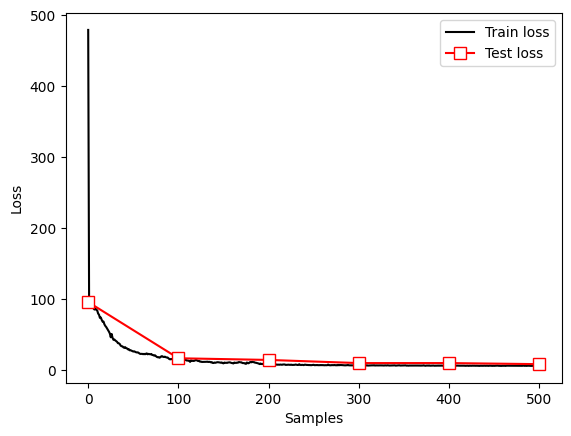

In [23]:
# plot the losses
plt.plot(train_loss,'k',label='Train loss')
plt.plot(range(0,num_samples,100),test_loss[::100],'rs-',markerfacecolor='w',markersize=8,label='Test loss')

plt.legend()
plt.gca().set(xlabel='Samples',ylabel='Loss')
plt.show()

In [24]:
# Generate new text
model.eval()
with torch.no_grad():
    start_tokens = torch.tensor(tokenizer.encode("I love coding in Python"),
                                dtype=torch.long, device=device).unsqueeze(0)

    Y = model.generate(start_tokens, temperature=1.0, max_new_tokens=100)

print(tokenizer.decode(Y[0].tolist()).replace('\r','\n'))


I love coding in Pythong sorts; proud Providence left; to ministers to the articles,

al a who had Amsterdam in both theos myself. He wouldside of some admired in the well might sea, andward, immediately sea hemother. But the inhabitants;

 home roots, each immediately before held a made a thousand press anal by

 first and number for

 reason on therr at theith; thech day absolute end; for I piece could theame

J the
